## Import Library

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from itertools import product

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_percentage_error as mape


## Import dataset

In [7]:
df = pd.read_csv('../Data/clean/merged.csv')

## Exploratory Data Analysis

In [8]:
# Membuat data baru
df = df.groupby('Date')['Qty'].sum().reset_index()
# Set date as index
df = df.set_index('Date')
df.head()

,Qty
Date,
2022-01-01,49
2022-01-02,59
2022-01-03,63
2022-01-04,45
2022-01-05,28


In [203]:
# cek stationary
def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ", dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression:",dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)
        
ad_test(df['Qty'])

1. ADF :  -19.448086319449082
2. P-Value :  0.0
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression: 364
5. Critical Values :
	 1% :  -3.4484434475193777
	 5% :  -2.869513170510808
	 10% :  -2.571017574266393


Data bersifat stasioner, ditunjukkan oleh nilai p yang sangat rendah dan statistik ADF yang lebih negatif daripada nilai kritis pada berbagai tingkat signifikansi.

## Define the best parameters

In [ ]:
p = d = q = range(0, 90)
pdq = list(product(p, d, q))


best_mse, best_order = float("inf"), None

for order in pdq:
    try:
        model = ARIMA(df, order=order)
        model = model.fit()
        mse = mean_squared_error(df, model.fittedvalues)
        if mse < best_mse:
            best_mse, best_order = mse, order
    except:
        continue

print(f'Best ARIMA Order: {best_order} with MSE: {best_mse}')

## Build Model

In [5]:
# split data
train, test = train_test_split(df, test_size=0.2, shuffle=False)

model = ARIMA(train, order=(90,1,0))
model = model.fit()

# Save model
model.save('Model/arima.pkl')

with open('Model/arima.pkl', 'rb') as model_file:
    model = pickle.load(model_file)
n_forecast = len(test) + 30
forecast = model.forecast(steps=n_forecast)




## Visualization

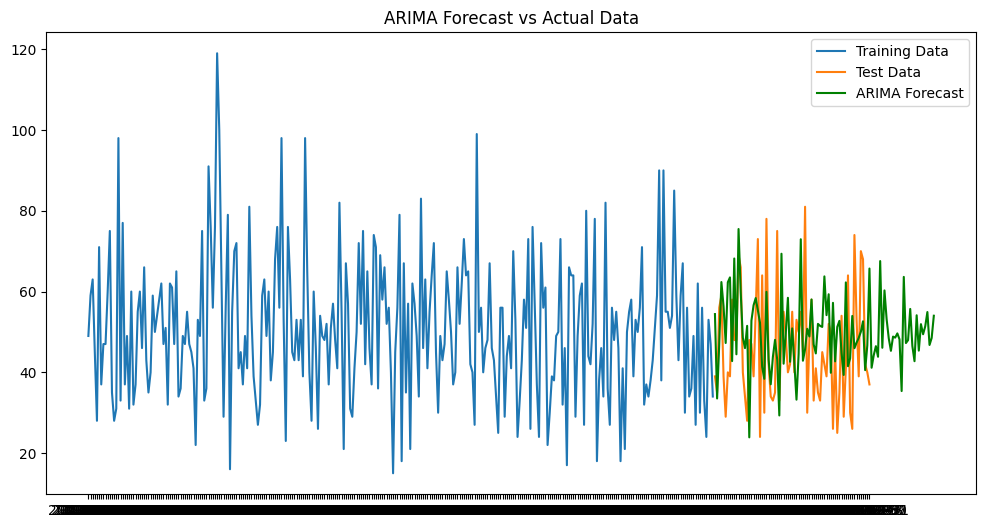

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(range(len(train), len(train) + n_forecast), forecast, label='ARIMA Forecast', color='green')
plt.title('ARIMA Forecast vs Actual Data')
plt.legend()
plt.show()


In [27]:
forecast.tail(30)

2023-01-01    41.132439
2023-01-02    44.228887
2023-01-03    46.477872
2023-01-04    43.849024
2023-01-05    67.546456
2023-01-06    46.075740
2023-01-07    60.278786
2023-01-08    53.183405
2023-01-09    48.406452
2023-01-10    45.325289
2023-01-11    48.845284
2023-01-12    48.589469
2023-01-13    49.636944
2023-01-14    48.174731
2023-01-15    35.361690
2023-01-16    63.630303
2023-01-17    47.241546
2023-01-18    47.969159
2023-01-19    55.691422
2023-01-20    46.510268
2023-01-21    42.755370
2023-01-22    54.125018
2023-01-23    45.371853
2023-01-24    51.922652
2023-01-25    49.424720
2023-01-26    51.402206
2023-01-27    54.925706
2023-01-28    46.766874
2023-01-29    48.518454
2023-01-30    54.012698
Freq: D, Name: predicted_mean, dtype: float64

## Evaluation

In [209]:
rmse = sqrt(mean_squared_error(test, forecast))
print('Test RMSE: %.3f' % rmse)

mape = mape(test, forecast)
print('Test MAPE: %.3f' % mape)

Test RMSE: 15.929
Test MAPE: 0.319
